###  Tutorial notebook v1  
## <span style="color:midnightblue">Genes2Genes (G2G) - A new alignment framework for single-cell gene expression trajectories </span>

<font size="4">
G2G aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.  <br> <br>

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). 
The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. 
There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison. 
</font>

In [1]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt

import os,sys,inspect
# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils

import warnings
warnings.filterwarnings("ignore")

In [2]:
import platform
print(platform.python_version())

3.8.8


### Input Reference and Query datasets to G2G 
<font size="4">
Load Reference anndata and Query anndata objects, each containing the log1p normalised expression matrices and the pseudotime values of all cells in their obs variable named 'time'. 
</font>

In [3]:
input_dir = '/nfs/team205/ds40/OrgAlign/TutorialData/'
adata_ref = anndata.read_h5ad(input_dir + 'adata_pam_local.h5ad') # PAM dataset
adata_query = anndata.read_h5ad(input_dir +'adata_lps_local.h5ad') # LPS dataset

<font size="4">
Examine their pseudotime distributions
</font>

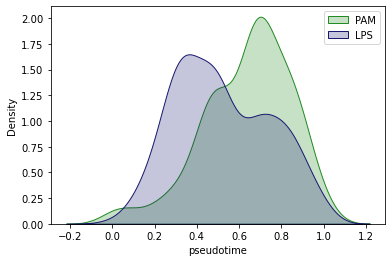

In [4]:
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='PAM', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='LPS', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

In [5]:
min(adata_ref.obs['time']), max(adata_ref.obs['time'])
min(adata_query.obs['time']), max(adata_query.obs['time'])

(0.0, 1.0)

If the min and max timepoints in the original pseudotime are not 0 and 1, respectively, we need to min-max normalize to ensure that they are within the [0,1] range. 
Uncomment below to do so. 

In [6]:
#x = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
#adata_ref.obs['time'] = x
#x = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))
#adata_query.obs['time'] = x

<font size="4">
Define the list of genes you are interested in analysing (e.g. Human transcription factor list, a set of marker genes, a regulon, Genes in a specific pathway). Here we use all the 89 genes in the input module. 
</font>


In [7]:
gene_list = adata_ref.var_names 
print(len(gene_list))
print(adata_ref)
print(adata_query)

89
AnnData object with n_obs × n_vars = 179 × 89
    obs: 'time'
AnnData object with n_obs × n_vars = 290 × 89
    obs: 'time'


## <span style="color:midnightblue"> Gene-level alignment </span> 

### Aligning a single gene

<font size='4'>
G2G finds an optimal alignment between the Reference and Query gene trajectories by matching or mismatching their respective time points based on the corresponding levels of gene expression. It first interpolates the data to smoothen the trajectories before generating an alignment. <br><br>
 <\font>    
Example: 

*SERTAD2*

In [8]:
# We first initialise an aligner object, passing the adata_ref, adata_query, the gene list of interest, and the number of timepoints to interpolate
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE = 0.1

In [9]:
# We can then run pairwise gene alignment calling the below function, which return an alignment object that carries all information about the alignment we estimated using G2G
al_obj = aligner.align_single_pair('SERTAD2')

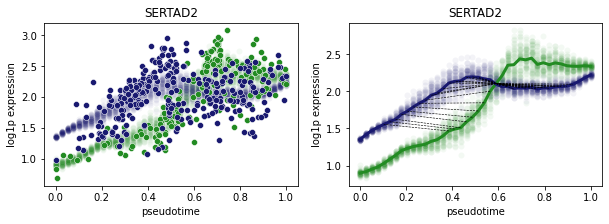

In [10]:
plt.subplots(1,2,figsize=(10,3))
plt.subplot(1,2,1)

# To plot the real cells and their interpolated trajectories (Reference in Green, and Query in Blue)
# NOTE: the bold points are real cells, whereas faded points represent random samples from the interpolated distributions 
al_obj.plotTimeSeries(aligner, plot_cells=True, plot_mean_trend=False)

plt.subplot(1,2,2)
# To plot the alignment between the trajectories (where matching timepoints are connected by dashed lines)
al_obj.plotTimeSeriesAlignment()

<font size='4'>
    G2G outputs an alignment with 5 different states: 
<ul>
<li>match (1-1 timepoint match) (M)</li>
<li>warp_compression (many-1 timepoint match) (W)</li>
<li>warp_expansion (1-many timepoint match) (V)</li>
<li>deletion (mismatch w.r.t query) (D)</li>
<li>insertion (mismatch w.r.t reference) (I)</li>
</ul>

In [11]:
# To output the 5-state alignment description 
print(al_obj.al_visual)

01234567890123456789012345678901234567890123456789012345678901234567890 Alignment index 
    012345678901234567890123333333333333333333333333   4567890123456789 Reference index
----************************^^^^^^^^^^^^^^^^^^^^^^^^---****************
****---------------************************************----------------
0123               456789012345678901234567890123456789                 Query index
IIIIDDDDDDDDDDDDDDDMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVVVIIIDDDDDDDDDDDDDDDD 5-state string 


<br>
<font size='4'>
    The star (*) represents a timepoint in a trajectory. <br>
   Top line of stars represent the sequence of time points in the reference. <br>
    Bottom line of stars represent the sequence of time points in the query.<br>
    Matched timepoints are highlighted in green. Mismatched timepoints are highlighted in red. <br>
    The symbol ^ refers to a warp (1-to-many or many-to-1 match). 
<br><br>

In [12]:
al_obj.print_alignment()

01234567890123456789012345678901234567890123456789012345678901234567890 Alignment index 
    012345678901234567890123333333333333333333333333   4567890123456789 Reference index
----************************^^^^^^^^^^^^^^^^^^^^^^^^---****************
****---------------************************************----------------
0123               456789012345678901234567890123456789                 Query index
IIIIDDDDDDDDDDDDDDDMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVVVIIIDDDDDDDDDDDDDDDD 5-state string 
Matched percentages: 
w.r.t alignment:  46.48 %
w.r.t ref:  22.5 %
w.r.t query:  82.5 %


In [13]:
#We can quantify the alignment using the optimal alignment cost measured in nits
print('optimal alignment cost = ' , al_obj.fwd_DP.opt_cost, 'nits') 

# We can get the alignment similarity (match) percentage between ref and query, in terms of (1) the alignment, (2) w.r.t ref and (3) w.r.t query
al_obj.get_series_match_percentage() 

optimal alignment cost =  81.90311513544337 nits


(46.48, 22.5, 82.5)

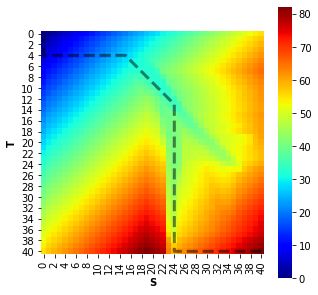

In [14]:
# We can visualise the optimal alignment cost landscape and highlight the alignment path through it
al_obj.landscape_obj.plot_alignment_landscape() 

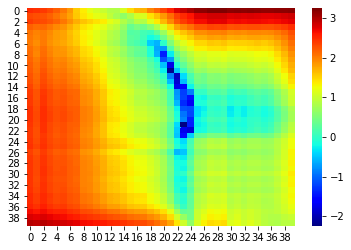

In [15]:
# We can visualise the pairwise cost matrix where each cell gives the G2G distance measure between each pair of reference timepoint and query timepoint. 
aligner.show_pairwise_distance_matrix(al_obj)

### Aligning all genes in the given list at once

In [16]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, 40)
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.align_all_pairs()

WINDOW_SIZE= 0.1


  0%|          | 0/89 [00:00<?, ?it/s]

<font size='4'>
    We can access the alignment object of each gene result through its results_map dictionary

In [17]:
aligner.results_map['IL1A']

01234567890123456789012345678901234567890123456789012345678901 Alignment index 
                   0123456789012345678901234567890123456789    Reference index
-------------------****************************************---
*******************----------------------*********************
0123456789012345678                      901234567890123456789 Query index
IIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMIII 5-state string 
Matched percentages: 
w.r.t alignment:  29.03 %
w.r.t ref:  45.0 %
w.r.t query:  45.0 %


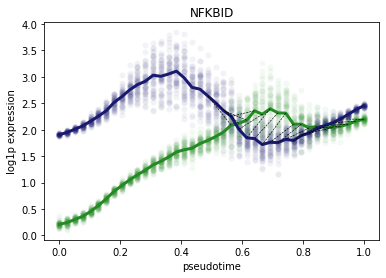

In [18]:
aligner.results_map['NFKBID'].plotTimeSeriesAlignment()
aligner.results_map['NFKBID'].print_alignment()

<font size='4'>
    Get the overall aggregate alignment across all genes
    

Average alignment 5-state string:  IIIIIIIDDDDDDDDDDDDDDMMMMMMMMMMMVVVVVVVVVVVVVVVVVVDDDDDDIDDIIDDDDIDDD


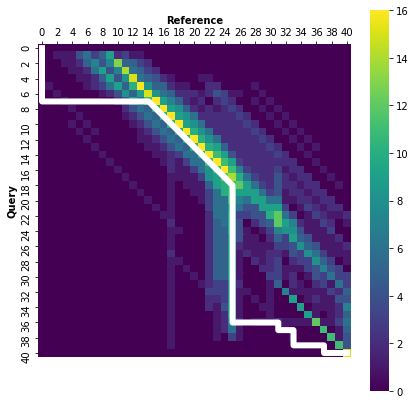

In [19]:
vs = VisualUtils.VisualUtils(adata_ref, adata_query, cell_type_colname = 'time', 
                S_len=len(aligner.results[0].S.time_points), 
                T_len=len(aligner.results[0].T.time_points), 
                titleS='PAM (Reference)', titleT='LPS(Query)',
                write_file=False)

overall_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list)
print('Average alignment 5-state string: ', overall_alignment)
mat = aligner.get_pairwise_match_count_mat()
VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)

<font size='4'>
    
    <b>Clustering alignments </b><br>
    We can cluster all the generated 5-state alignments to identify groups of genes with similar alignment patterns. Here we encode alignments under a binary scheme, compute pairwise hamming distance matrxi and perform agglomerative hierarchical clustering. <br>
Below plot gives all gene alignment paths in each cluster (Each plot title gives the Cluster-ID | number of genes in the cluster)

run


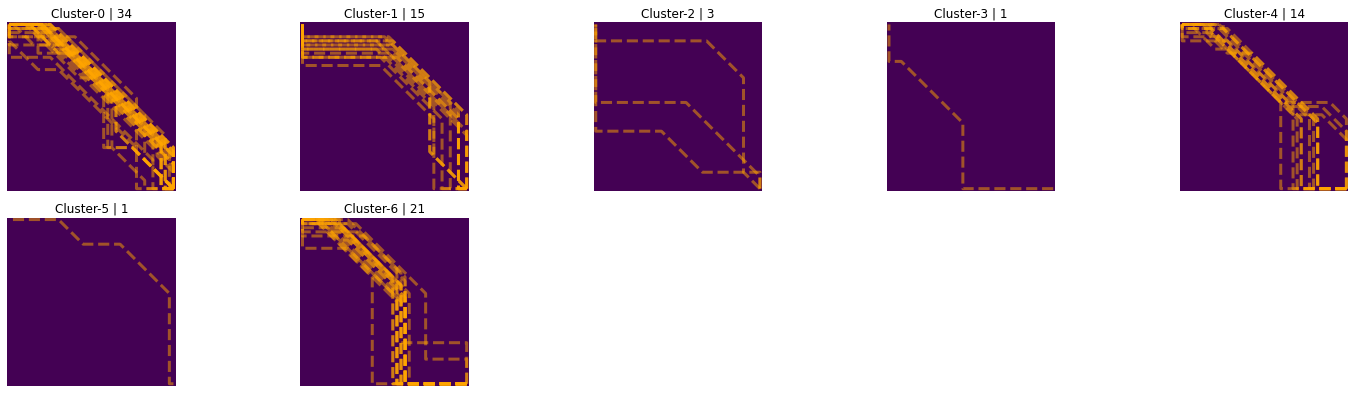

In [20]:
ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner, DIST_THRESHOLD=0.3)

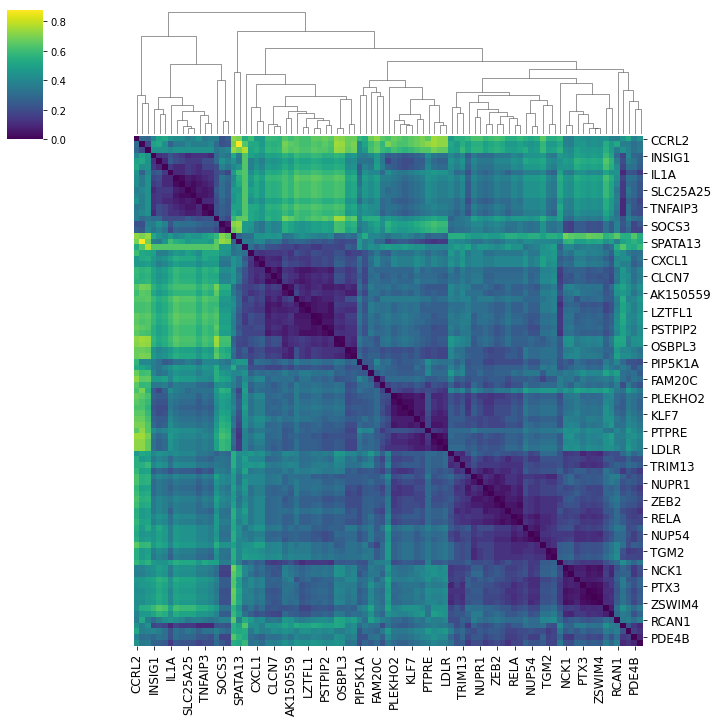

In [21]:
p = sb.clustermap(aligner.DistMat,cmap='viridis', figsize=(10,10))
p.ax_heatmap.set_xticklabels(p.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
p.ax_heatmap.set_yticklabels(p.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
p.ax_row_dendrogram.set_visible(False)

<font size='4'>
    We can access the gene clusters 

In [22]:
len(aligner.gene_clusters) # number of clusters

7

In [23]:
# to get the list of genes belonging to the cluster
print(aligner.gene_clusters[0]) # Cluster-0
print(aligner.gene_clusters[1]) # Cluster-1
print(aligner.gene_clusters[2]) # Cluster-2
print(aligner.gene_clusters[5]) # Cluster-5

['ARG2', 'ARHGEF3', 'BC031781', 'BCL2L11', 'CD44', 'CDC42EP4', 'CLEC4D', 'DDHD1', 'DUSP16', 'FAM108C', 'GRAMD1B', 'ICOSL', 'IRAK-2', 'MCOLN2', 'NCK1', 'NFKBIE', 'NUP54', 'NUPR1', 'PDE4B', 'PIP5K1A', 'PLAGL2', 'PTAFR', 'PTX3', 'RASA2', 'RBM7', 'RELA', 'RFFL', 'SGMS2', 'SLC25A37', 'TGM2', 'TLR2', 'TRIM13', 'ZEB2', 'ZSWIM4']
['CXCL2', 'FLRT3', 'H1F0', 'IL1A', 'INSIG1', 'MALT1', 'NFKBIA', 'NFKBIZ', 'NLRP3', 'RALGDS', 'RASGEF1B', 'SLC25A25', 'SOCS3', 'TNF', 'TNFAIP3']
['CCRL2', 'NFKBID', 'PLK2']
['RCAN1']


In [24]:
# to access cluster ids of all alignment objects
print(aligner.cluster_ids) 

[5 6 6 1 0 4 1 6 6 0 0 6 1 1 0 0 0 1 1 0 1 0 4 0 0 0 0 6 0 0 0 1 6 1 0 1 6
 4 4 4 6 0 0 0 0 3 2 0 0 4 6 0 1 4 0 0 6 6 4 6 4 0 0 2 6 6 4 6 1 4 6 6 4 6
 0 0 1 1 6 0 6 2 0 0 4 0 0 4 1]


In [25]:
# to print the alignments strings in a cluster
aligner.show_cluster_alignment_strings(cluster_id=1)

IIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIDD
IIIIIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIDD
IIIIIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIDD
IIIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIDD
IIIIIIIIDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIII
IIIIDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIII
IIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIII
IIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIDDDD
IIIIIIDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIDDDDDDDD
IIIDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIII
IIIIIIIIIIDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMIIIIIIIIIMMMMMMMM
IIIIIIIIDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIDDDDDD
IIIIDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMIIVVVVVVVVVVVVVVVMMMMMMMMM
IIIIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIDD
IIIIIDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMVVVVVVVVVVVVVVVIMMMMMMMMM


<font size='4'>
    E.g. Cluster-specific average alignment for cluster 0

Cluster specific average alignment 5-state string:  IIIIDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMVMIIMIIIIDI


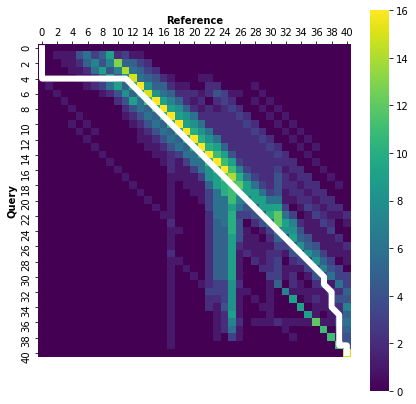

In [26]:
average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[0] )
print('Cluster specific average alignment 5-state string: ', average_alignment)
VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)

<font size='4'>
    E.g. Cluster-specific average alignment for cluster 1

Cluster specific average alignment 5-state string:  IIIIIIIIDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIDIID


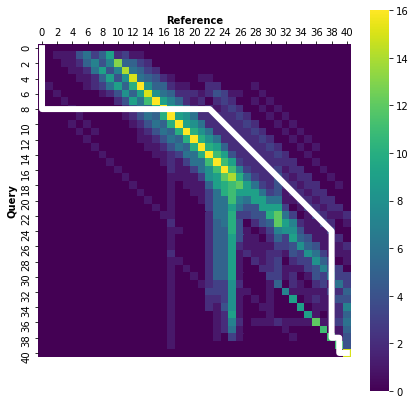

In [27]:
average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[1] )
print('Cluster specific average alignment 5-state string: ', average_alignment)
VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)

<font size='4'>
    Cluster specific overepresentation analysis 

In [28]:
# Clusters do not necessarily output similar gene programs 
# If one pathway is overrepresented in several clusters, that means the particular pathway has several gene subsets which match/mismatch differently along pseudotime. 
# Such clusters reveal pathways with varying alignment patterns
# A cluster might not have any significant overepresentation result as well
PathwayAnalyserV2.run_cluster_overrepresentation_analysis(aligner)

100%|██████████| 7/7 [00:17<00:00,  2.55s/it]

+----+--------------+-----------+--------------------------------+------------------------------------------+------------------------------------------+------------+
|    |   cluster_id |   n_genes | Cluster genes                  | Pathways                                 | Pathway genes                            | Source     |
+====+==============+===========+================================+==========================================+==========================================+============+
|  0 |            0 |        34 | ['ARHGEF3', 'BC031781',        | ['TNF-alpha Signaling via NF-kB',        | ['PDE4B;PTX3;NFKBIE;CD44;RELA;TLR2',     | ['MSigDB', |
|    |              |           | 'BCL2L11', 'CD44', 'CDC42EP4', | 'Mitotic Spindle', 'Inflammatory         | 'BCL2L11;CDC42EP4;RASA2;ARHGEF3;NCK1',   | 'MSigDB',  |
|    |              |           | 'CLEC4D', ' ... ', 'SGMS2',    | Response', 'Epstein-Barr virus           | 'PTAFR;PDE4B;SGMS2;RELA;TLR2',           | 'MSigDB',  |
|   

We can also order the genes based on their alignments by ordering them in their first match between reference and query along the pseudotime. This shows us which genes first started to match between the 2 systems, and may give a cascading order in matches along the pseudotime if there exists any.


In [30]:
ordered_gene_list = aligner.show_ordered_alignments()

Gene      Alignment
--------  -----------------------------------------------------------------------
RFFL      DMMMMMWWWWWWWWMMMMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIII
FAM20C    DDMMMMMMDDDMMMMMMMMMMMMMMMMDDDDDDDMMMMMMIIIIIIIIIIII
FPR1      DDDMMMMMMMMMMMMMMMMMMMMVVVVVVVVVVVVIIIIIIIIDDDDDDDDDDDDDDDDD
OSBPL3    DDDDMMMMMMMMMMMMMMMMMMMVVVVVVVVVVVVVIIIIIIIIDDDDDDDDDDDDDDDDD
BCL2L11   DDDDMMMMMMMMMMMMMDDMMMMMMMMMMMMMMMMMMMMMIIIIII
CLEC4D    IIIIMMMMMMMDDDDDMMMMMMMMMMMMMMMMMMMIIIIIIIIIIDDDDDDDDD
AK163103  DDDDMMMMMDDMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVIIDDDDDDDDDDDDDDD
SGMS2     DDDDMMMIIIIDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMIIIIIIII
F10       DDDDIMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVVVVVVVVVIDDDDDDDDDDDDDDDDDDDDDDD
TSHZ1     DDDDDMMMMMMMMMMMMMMMMMMMMVVVVVVVVVVVVVVVVVIIIDDDDDDDDDDDDDDD
SPATA13   DDDDDMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDD
TGM2      DDDDDMMMMMMMDDDDMMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIII
TLR2      DDDDDMMMMMMMDDDDDMMMMMMMMMMMMMMMMMMMMMMMIIIIIIIIII
MCOLN2    DDDDDMMMMMMDDMMMMMMMMMM

Plot the alignment and their respective real cell trajectories for a specific gene/gene-set, separately

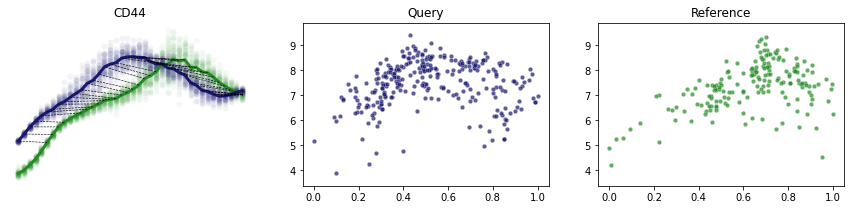

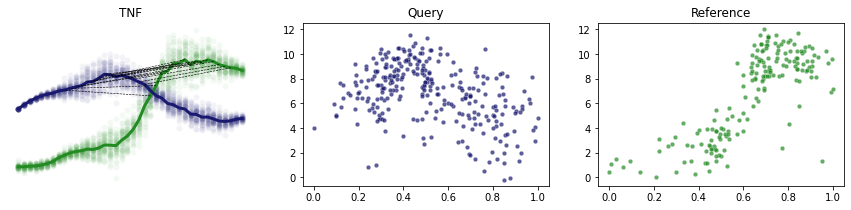

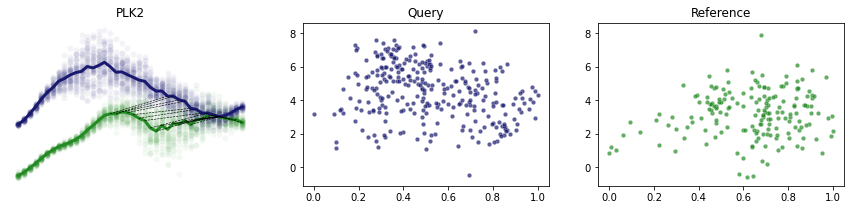

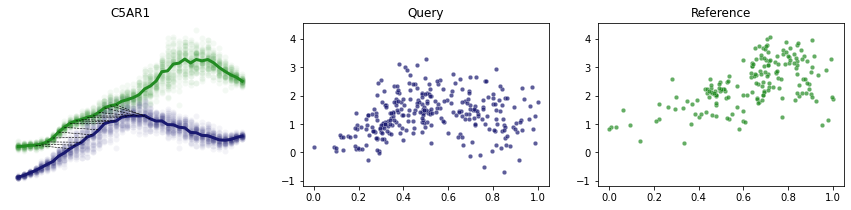

In [31]:
genes_of_interest = ['CD44','TNF','PLK2', 'C5AR1']
    
for g in genes_of_interest:
    VisualUtils.plotTimeSeries(aligner.results_map[g], aligner, plot_cells=True) 

<font size='4'>
    Alignment distribution, and a quantitative measure of the degree of similarity between reference and query trajectories

mean matched percentage:  50.85 %
mean matched percentage wrt ref:  56.4 %
mean matched percentage wrt query:  70.73 %


Text(0.5, 0, 'Alignment Similarity Percentage')

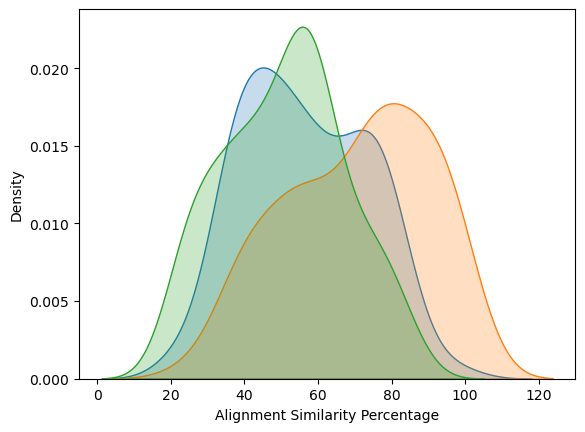

In [32]:
# The overall alignment distribution statistics
import matplotlib as mpl
mpl.style.use('default')
df = aligner.get_match_stat_for_all_genes() 
print('mean matched percentage: ', round(np.mean(df['match %']),2),'%' )
print('mean matched percentage wrt ref: ',round(np.mean(df['match % S']),2),'%'  )
print('mean matched percentage wrt query: ', round(np.mean(df['match % T']),2),'%' )
sb.kdeplot(df['match % S'], fill=True, label='match % Reference')
sb.kdeplot(df['match % T'], fill=True,label='match % Query')
sb.kdeplot(df['match %'], fill=True,label='Alignment Similarity %')
#plt.legend()
plt.xlabel('Alignment Similarity Percentage')

In [33]:
df

,match %,match % S,match % T,cluster_id
0,54.84,65.0,65.0,5.0
1,53.33,50.0,80.0,6.0
2,56.25,40.0,90.0,6.0
3,23.08,37.5,37.5,1.0
4,80.00,75.0,100.0,0.0
...,...,...,...,...
84,31.15,47.5,47.5,4.0
85,66.67,80.0,80.0,0.0
86,60.00,75.0,75.0,0.0
87,40.35,57.5,57.5,4.0


In [34]:
# average matched percentage by alignment cluster
df.columns = ['match %','match % Reference','match % Query','cluster_id']
df.groupby('cluster_id').mean()

,match %,match % Reference,match % Query
cluster_id,,,
0.0,65.021471,73.897059,81.323529
1.0,31.515333,43.833333,48.833333
2.0,32.073333,45.000000,42.500000
3.0,23.080000,37.500000,37.500000
4.0,38.927857,56.071429,55.000000
5.0,54.840000,65.000000,65.000000
6.0,53.472381,39.404762,85.595238


<font size='4'>
    Getting a ranked list of genes according to their alignment similarity percentage <br>
    
The top genes with the lowest alignment similarity percentages indicate differential expression along the time axis

In [35]:
x =  PathwayAnalyserV2.get_ranked_genelist(aligner)
x = pd.DataFrame(x)

In [36]:
x

,Alignment_Percentage
Gene,
CXCL2,0.2121
TNF,0.2308
C5AR1,0.2308
NLRP3,0.2308
MALT1,0.2500
...,...
RFFL,0.7959
NFKBIE,0.8000
PTX3,0.8125


<font size='4'>
    Plotting alignment similarity percentage against their log2fold change expression

In [37]:
l2fc = []
for gene in x.index:
    l2fc.append(np.log2(np.mean(list(aligner.ref_mat.loc[:,gene]))/np.mean(list(aligner.query_mat.loc[:,gene])) )) 
x[2] = l2fc
x.columns = ['sim','l2fc']
x['color'] = np.repeat('green',x.shape[0])
x.loc[x['sim']<=0.5,'color'] = 'red'
x['abs_l2fc'] = np.abs(x['l2fc']) 
x = x.sort_values(['sim','abs_l2fc'],ascending=[True, False])

x

,sim,l2fc,color,abs_l2fc
Gene,,,,
CXCL2,0.2121,0.112200,red,0.112200
C5AR1,0.2308,0.871100,red,0.871100
NLRP3,0.2308,0.069058,red,0.069058
TNF,0.2308,-0.006439,red,0.006439
ORAI2,0.2500,0.389254,red,0.389254
...,...,...,...,...
RFFL,0.7959,0.022059,green,0.022059
NFKBIE,0.8000,-0.081771,green,0.081771
PTX3,0.8125,-0.048521,green,0.048521


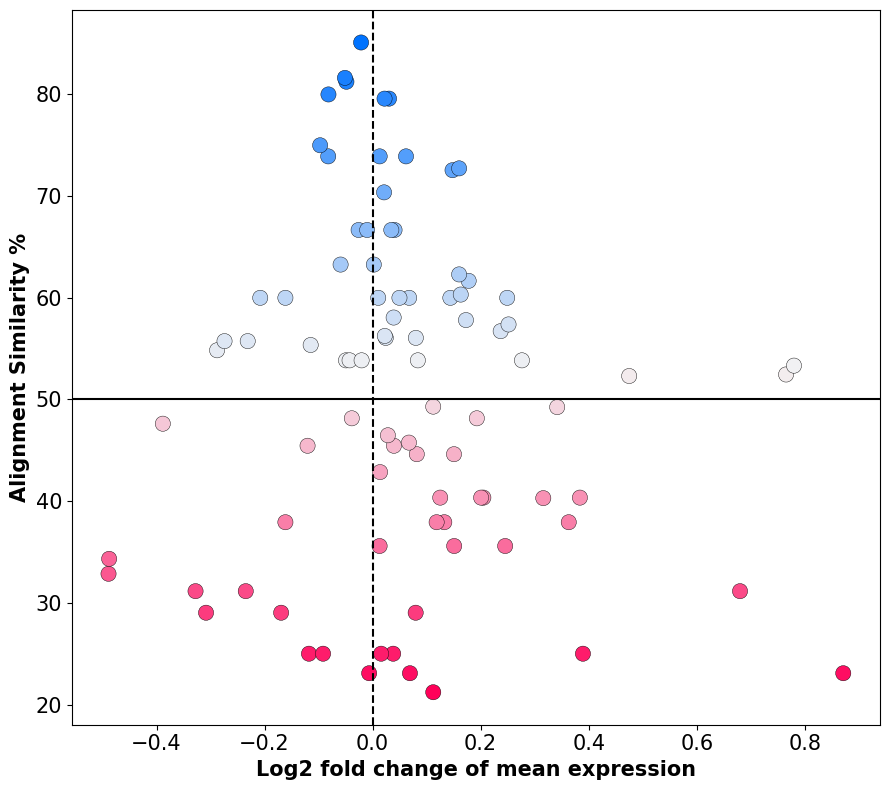

In [38]:
VisualUtils.plot_alignmentSim_vs_l2fc(x)

<font size='4'>
    Pathway overrepresentation analysis over the top genes of low alignment similarity percentage

In [39]:
# Overrepresentation analysis of the top DE genes along pseudotime based on alignment percentage < 50% 
topDEgenes,rankedDEgenes = PathwayAnalyserV2.topkDE(aligner, DIFF_THRESHOLD=0.5)
df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes)
df

41  # of DE genes to check


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,12/200,4.393371e-15,1.010475e-13,0,0,43.516508,1438.598288,NFKBIA;IL1A;PTPRE;TNIP1;PLK2;CCRL2;TNFAIP2;TNF...,12.995474,12.995474
1,MSigDB_Hallmark_2020,Inflammatory Response,9/200,2.217840e-10,2.550515e-09,0,0,29.108639,647.065169,NFKBIA;IL1A;PTPRE;ADORA2B;C5AR1;CCRL2;NLRP3;LC...,8.593372,8.593372
23,KEGG_2021_Human,NF-kappa B signaling pathway,6/104,6.628780e-08,7.357946e-06,0,0,34.742274,574.264080,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF;MALT1,5.133243,5.133243
26,KEGG_2021_Human,C-type lectin receptor signaling pathway,5/104,2.228337e-06,6.183634e-05,0,0,27.861953,362.602563,NFKBIA;CLEC4D;NLRP3;TNF;MALT1,4.208756,4.208756
25,KEGG_2021_Human,NOD-like receptor signaling pathway,6/181,1.747605e-06,6.183634e-05,0,0,19.380245,256.929024,NFKBIA;TNFAIP3;NLRP3;CXCL1;CXCL2;TNF,4.208756,4.208756
24,KEGG_2021_Human,IL-17 signaling pathway,5/94,1.350171e-06,6.183634e-05,0,0,31.008115,419.083326,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF,4.208756,4.208756
27,KEGG_2021_Human,TNF signaling pathway,5/112,3.211873e-06,7.130358e-05,0,0,25.768432,325.936039,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF,4.146889,4.146889
28,KEGG_2021_Human,Lipid and atherosclerosis,6/215,4.727025e-06,8.744996e-05,0,0,16.199590,198.642847,NFKBIA;NLRP3;CXCL1;CXCL2;TNF;LDLR,4.058240,4.058240
29,KEGG_2021_Human,Legionellosis,4/57,5.548808e-06,8.798825e-05,0,0,40.603774,491.383918,NFKBIA;CXCL1;CXCL2;TNF,4.055575,4.055575
30,KEGG_2021_Human,Yersinia infection,5/137,8.614479e-06,1.195259e-04,0,0,20.861742,243.291021,NFKBIA;NLRP3;PIP5K1A;LCP2;TNF,3.922538,3.922538


,Pathways,Pathway genes,Source
0,TNF-alpha Signaling via NF-kB,NFKBIA;IL1A;PTPRE;TNIP1;PLK2;CCRL2;TNFAIP2;TNF...,MSigDB_Hallmark_2020
1,Inflammatory Response,NFKBIA;IL1A;PTPRE;ADORA2B;C5AR1;CCRL2;NLRP3;LC...,MSigDB_Hallmark_2020
23,NF-kappa B signaling pathway,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF;MALT1,KEGG_2021_Human
26,C-type lectin receptor signaling pathway,NFKBIA;CLEC4D;NLRP3;TNF;MALT1,KEGG_2021_Human
25,NOD-like receptor signaling pathway,NFKBIA;TNFAIP3;NLRP3;CXCL1;CXCL2;TNF,KEGG_2021_Human
24,IL-17 signaling pathway,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF,KEGG_2021_Human
27,TNF signaling pathway,NFKBIA;TNFAIP3;CXCL1;CXCL2;TNF,KEGG_2021_Human
28,Lipid and atherosclerosis,NFKBIA;NLRP3;CXCL1;CXCL2;TNF;LDLR,KEGG_2021_Human
29,Legionellosis,NFKBIA;CXCL1;CXCL2;TNF,KEGG_2021_Human
30,Yersinia infection,NFKBIA;NLRP3;PIP5K1A;LCP2;TNF,KEGG_2021_Human


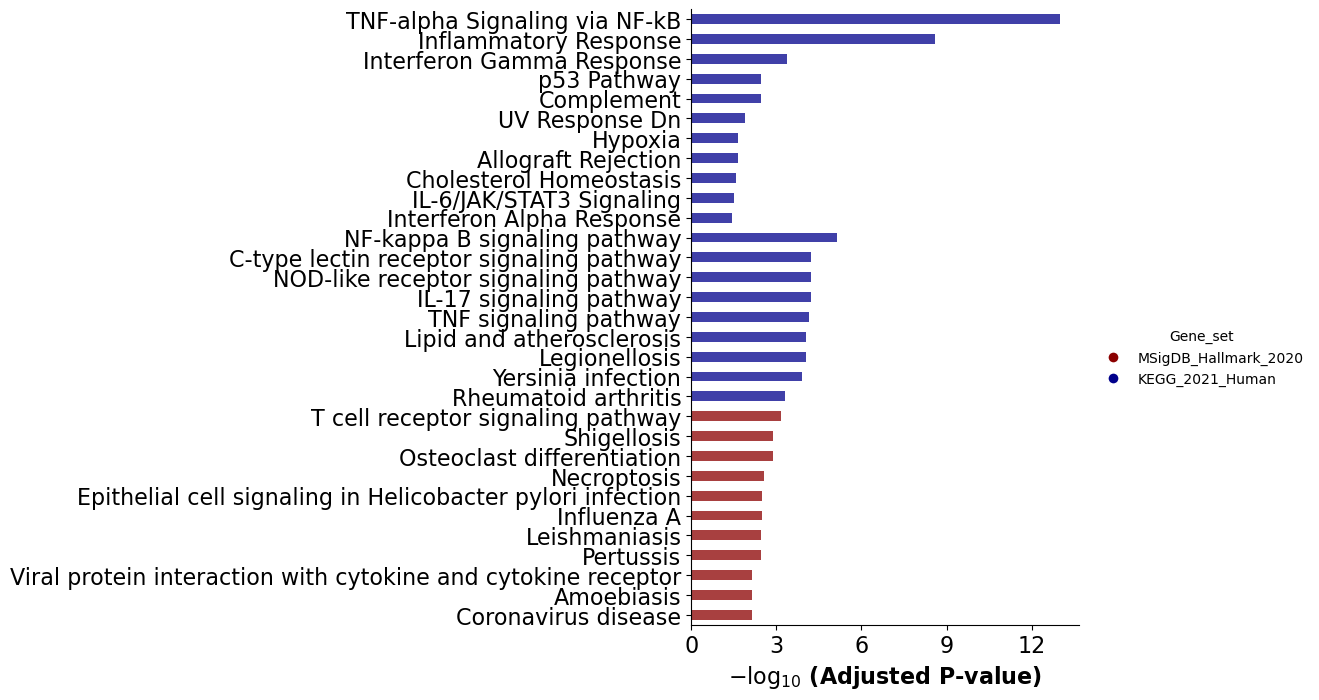

In [40]:
PathwayAnalyserV2.plot_overrep_results(df)
df = pd.DataFrame([df.Term, df.Genes, df.Gene_set]).transpose() 
df.columns = ['Pathways','Pathway genes','Source']
df

<font size='4'>
Complementary analysis -- Checking mean expression trend heatmaps for given list of genes

Interpolated mean trends


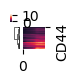

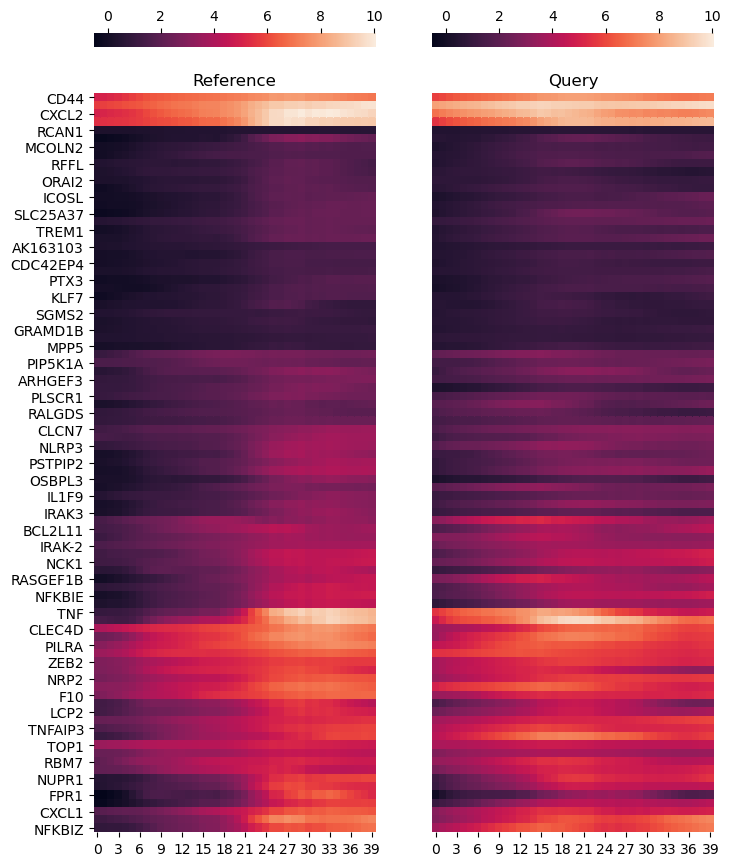

Z-normalised Interpolated mean trends


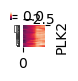

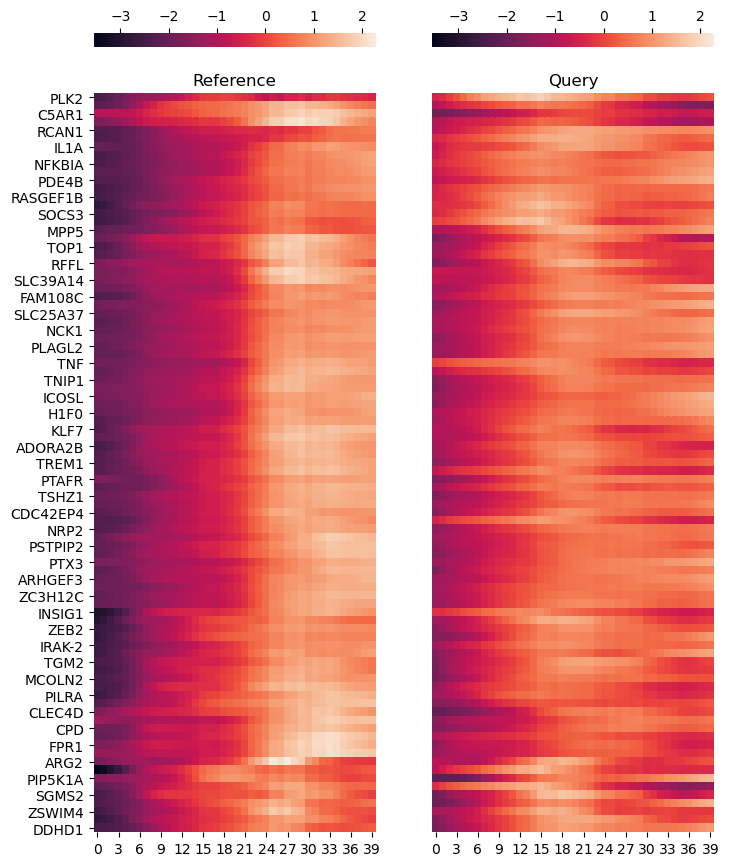

In [41]:
IGS = PathwayAnalyserV2.InterestingGeneSets()
IGS.SETS['all_genes'] = aligner.gene_list
VisualUtils.plot_mean_trend_heatmaps('all_genes', IGS, aligner, cluster=True) 

Interpolated mean trends


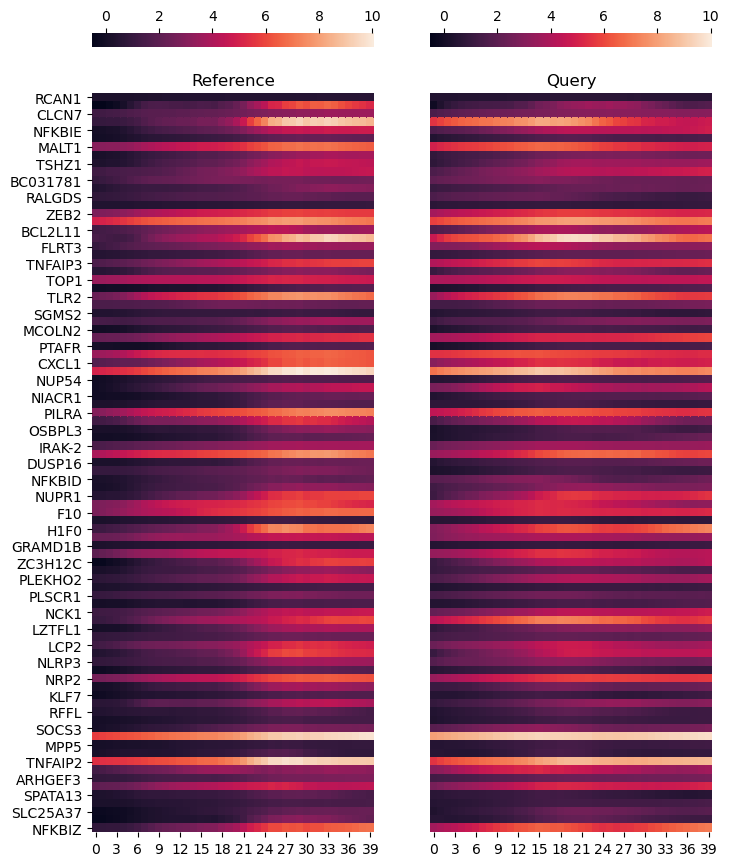

Z-normalised Interpolated mean trends


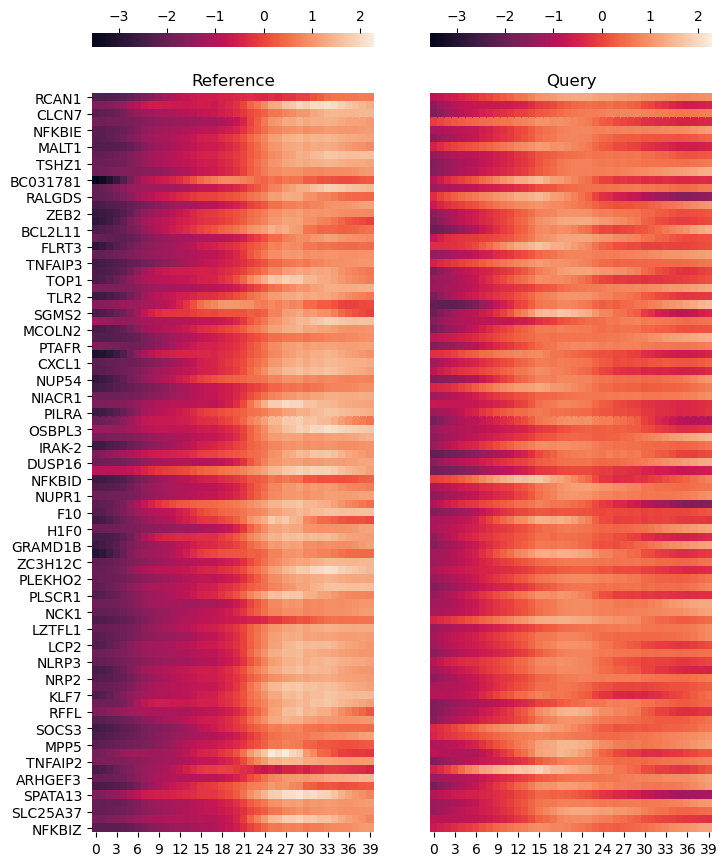

In [42]:
VisualUtils.plot_mean_trend_heatmaps('all_genes', IGS,aligner,  cluster=False) 